In [1]:
import os
import gc
import numpy as np

from scipy.optimize import curve_fit
from obspy import UTCDateTime
from pandas import DataFrame, date_range

import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('../')

In [3]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

In [4]:
config = {}

config['path_to_data'] = data_path+f"ids/"

config['path_to_outdata'] = data_path+"ids/data/"

config['path_to_figures'] = data_path+"ids/figures/"

# experiment with cameras pararell at different rings (from 2024-05-22)
config['date1'] = "2024-05-23"
config['date2'] = "2024-06-20"

# after adjustment
config['date1'] = "2024-07-06"
config['date2'] = "2024-07-08"

# conversion from pixel to mm
config['conversion'] = {"XX":1.67e-3,
                        "03":5.3e-3,
                        "07":5.3e-3,
                       }


In [5]:
from functions.load_mlti import __load_mlti
from functions.get_mlti_intervals import __get_mlti_intervals
from functions.mlti_intervals_to_NaN import __mlti_intervals_to_NaN

In [6]:
mltiU = __load_mlti(config['date1'], config['date2'], "U", archive_path)
mltiU_t1, mltiU_t2 = __get_mlti_intervals(mltiU.time_utc)

mltiZ = __load_mlti(config['date1'], config['date2'], "Z", archive_path)
mltiZ_t1, mltiZ_t2 = __get_mlti_intervals(mltiZ.time_utc)

mltiV = __load_mlti(config['date1'], config['date2'], "V", archive_path)
mltiV_t1, mltiV_t2 = __get_mlti_intervals(mltiV.time_utc)


In [7]:
def __load_beam_wander_data(tbeg, tend, path_to_data, cam):

    from obspy import UTCDateTime
    from datetime import date
    from pandas import read_pickle, concat, DataFrame, date_range, to_datetime

    path_to_data += f"data{cam}/"

    t1 = date.fromisoformat(str(UTCDateTime(tbeg).date))
    t2 = date.fromisoformat(str((UTCDateTime(tend)).date))

    df = DataFrame()
    for dat in date_range(t1, t2):
        print(str(dat)[:10])
        file = f"{str(dat)[:10].replace('-','')}.pkl"
        try:
            df0 = read_pickle(path_to_data+file)
            df = concat([df, df0])
        except:
            print(f"error for {file}")

    # remove NaN from time column
    df.dropna(subset=['time'], inplace=True)

    # reset the index column
    df.reset_index(inplace=True, drop=True)

    # add column for relative time in seconds
    df['time_sec'] = [UTCDateTime(_t) - UTCDateTime(df.time.iloc[0]) for _t in df.time]

    return df

In [8]:
df = __load_beam_wander_data(config['date1'], config['date2'], config['path_to_data'], "")

2024-07-06
2024-07-07
2024-07-08
error for 20240708.pkl


In [9]:
df3 = __load_beam_wander_data(config['date1'], config['date2'], config['path_to_data'], "03")

2024-07-06
2024-07-07
2024-07-08
error for 20240708.pkl


In [10]:
df3

,time,x,y,x_idx,y_idx,amp,x_sig,y_sig,theta,offset,x_var,y_var,amp_var,y_sig_var,x_sig_var,theta_var,offset_var,time_sec
0,2024-07-06T00:06:07.000000Z,582.327625,413.466332,582.0,413.0,79.514462,143.322224,146.601233,1.129144,3.143048,0.000422,0.000410,0.000125,0.000495,0.000471,0.000019,0.000005,0.0
1,2024-07-06T00:09:06.000000Z,582.329345,413.433439,582.0,413.0,80.065201,143.309493,146.613291,1.135710,2.821676,0.000421,0.000409,0.000127,0.000494,0.000470,0.000019,0.000005,179.0
2,2024-07-06T00:16:06.000000Z,582.338839,413.398301,582.0,413.0,79.961752,143.319800,146.597207,1.127090,3.052104,0.000421,0.000409,0.000126,0.000494,0.000470,0.000019,0.000005,599.0
3,2024-07-06T00:24:07.000000Z,582.339477,413.444340,582.0,413.0,79.867625,143.313319,146.593971,1.130869,3.021727,0.000422,0.000410,0.000126,0.000495,0.000471,0.000019,0.000005,1080.0
4,2024-07-06T00:28:06.000000Z,582.338152,413.474145,582.0,413.0,79.791108,143.316160,146.593447,1.126336,3.249793,0.000421,0.000410,0.000126,0.000494,0.000471,0.000019,0.000005,1319.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,2024-07-07T23:08:06.000000Z,582.224384,414.046322,582.0,414.0,78.086765,143.297144,146.576048,1.133539,3.123171,0.000417,0.000406,0.000119,0.000489,0.000466,0.000019,0.000005,169319.0
284,2024-07-07T23:10:06.000000Z,582.213598,414.089541,582.0,414.0,78.217543,143.298273,146.586647,1.126479,3.301118,0.000417,0.000406,0.000120,0.000489,0.000466,0.000019,0.000005,169439.0
285,2024-07-07T23:18:07.000000Z,582.206626,413.981763,582.0,414.0,79.277841,146.621372,143.288480,-0.431550,3.128662,0.000411,0.000399,0.000121,0.000458,0.000482,0.000018,0.000005,169920.0
286,2024-07-07T23:30:07.000000Z,582.203359,414.038210,582.0,414.0,78.858227,143.275278,146.593521,1.135709,3.216767,0.000415,0.000403,0.000121,0.000486,0.000463,0.000019,0.000005,170640.0


In [11]:
df7 = __load_beam_wander_data(config['date1'], config['date2'], config['path_to_data'], "07")

2024-07-06
2024-07-07
2024-07-08
error for 20240708.pkl


### Remove MLTI times

In [12]:
def __pre_process(df0, mlti_t1, mlti_t2, conversion_factor):

    from functions.reduce import __reduce

    # add utc object
    df0['time_utc'] = [UTCDateTime(tl) for tl in df0.time]

    keys_to_convert = ["y_idx", "x_idx", "y", "x", "x_sig", "y_sig"]

    for k in keys_to_convert:
        df0[k] *= conversion_factor

    # turn times with MLTI to NaN
    df0 = __mlti_intervals_to_NaN(df0, "y_idx", "time_utc", mlti_t1, mlti_t2, t_offset_sec=180)
    df0 = __mlti_intervals_to_NaN(df0, "x_idx", "time_utc", mlti_t1, mlti_t2, t_offset_sec=180)

    # remove bad estimates
    df0 = df0[df0['y_sig_var'] != np.inf]
    df0 = df0[df0['x_sig_var'] != np.inf]

    # when intensity is super low, there is a black image
    df0 = df0[df0['amp'] > 20]

    # when intensity is super high or saturated, there is likely a MLTI boost
    df0 = df0[df0['amp'] < 255]

    # to micrometer
    df0['x_um_rel'] = __reduce(df0.x, 100) * 1e3
    df0['y_um_rel'] = __reduce(df0.y, 100) * 1e3

    df0['x_um_sig'] = df0.x_sig * 1e1
    df0['y_um_sig'] = df0.y_sig * 1e1

    # df0['x_um_sig'] = __reduce(df0.x_sig, 10) * 1e3
    # df0['y_um_sig'] = __reduce(df0.y_sig, 10) * 1e3

    df0.reset_index(inplace=True)

    return df0

In [13]:
df = __pre_process(df, mltiU_t1, mltiU_t2, config['conversion']["XX"])

/home/brotzer/notebooks/BeamWander/functions/reduce.py:4: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return _dat - nanmean(_dat[:n_samples])
/home/brotzer/notebooks/BeamWander/functions/reduce.py:4: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return _dat - nanmean(_dat[:n_samples])


In [14]:
df7 = __pre_process(df7, mltiV_t1, mltiV_t2, config['conversion']["07"])

/home/brotzer/notebooks/BeamWander/functions/reduce.py:4: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return _dat - nanmean(_dat[:n_samples])
/home/brotzer/notebooks/BeamWander/functions/reduce.py:4: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return _dat - nanmean(_dat[:n_samples])


In [15]:
df3 = __pre_process(df3, mltiZ_t1, mltiZ_t2, config['conversion']["03"])

/home/brotzer/notebooks/BeamWander/functions/reduce.py:4: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return _dat - nanmean(_dat[:n_samples])
/home/brotzer/notebooks/BeamWander/functions/reduce.py:4: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return _dat - nanmean(_dat[:n_samples])


In [16]:
# correct offset for df7
# df7['x_um_rel'] = [x - 900 if x > 500 else x for x in df7.x_um_rel]

In [17]:
df7['x_um_rel'] = [np.nan if x < 140 else j for x, j in zip(df7.index, df7.x_um_rel)]
df7['y_um_rel'] = [np.nan if x < 140 else j for x, j in zip(df7.index, df7.y_um_rel)]

In [18]:
from functions.load_lxx import __load_lxx
from functions.get_lxx_intervals import __get_lxx_intervals

lxx =__load_lxx(config['date1'], config['date2'], archive_path)
lxx_t1, lxx_t2 = __get_lxx_intervals(lxx.datetime)


### Plotting

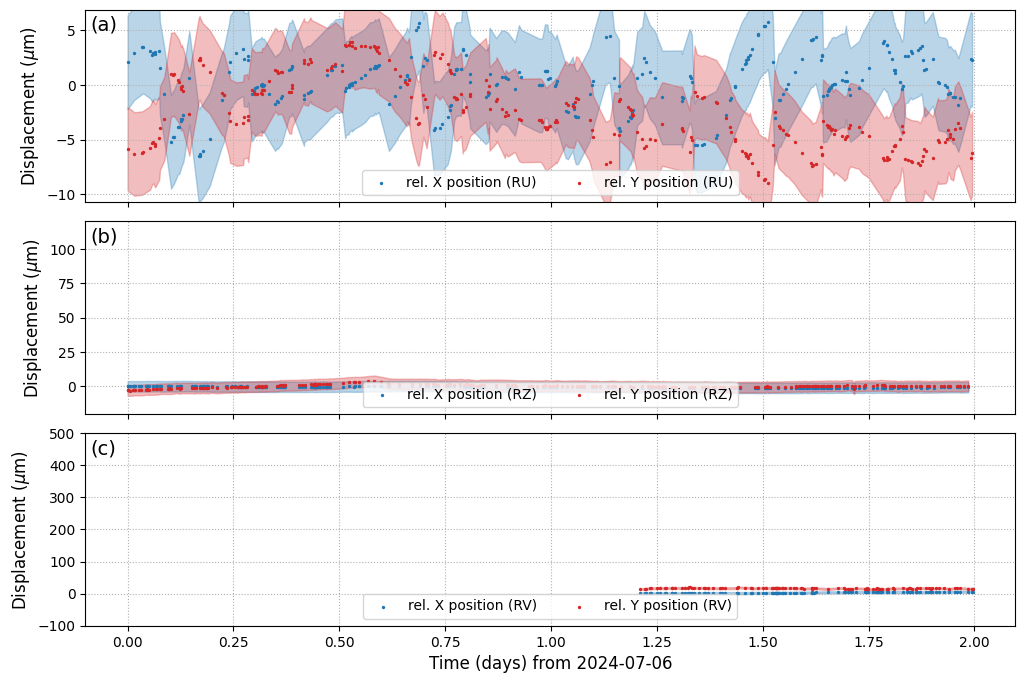

In [19]:
def __makeplot_overview():

    Nrow, Ncol = 3, 1

    font = 12
    size = 2
    tscale = 1/86400

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(12, 8), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    for n, (_df, ring) in enumerate(zip([df, df3, df7], ["RU", "RZ", "RV"])):

        ax[n].fill_between(_df.time_sec*tscale, _df.x_um_rel-abs(_df.x_um_sig)/2, _df.x_um_rel+abs(_df.x_um_sig)/2,
                           color="tab:blue", alpha=0.3, interpolate=False
                          )
        ax[n].scatter(_df.time_sec*tscale, _df.x_um_rel, s=size, zorder=2, color="tab:blue", label=f"rel. X position ({ring})")

        ax[n].fill_between(_df.time_sec*tscale, _df.y_um_rel-abs(_df.y_um_sig)/2, _df.y_um_rel+abs(_df.y_um_sig)/2,
                           color="tab:red", alpha=0.3, interpolate=False
                          )
        ax[n].scatter(_df.time_sec*tscale, _df.y_um_rel, s=size, zorder=2, color="tab:red", label=f"rel. Y position ({ring})")
        # ax[n].set_ylim(1.58, 1.69)
        ax[n].set_ylabel(f"Displacement ($\mu$m)", fontsize=font)

        ax[n].legend(loc=8, ncol=2)

        # add maintencane periods
        ref_date = config['date1']
        for lx1, lx2 in zip(lxx_t1, lxx_t2):
            lx1_sec = lx1-UTCDateTime(ref_date)
            lx2_sec = lx2-UTCDateTime(ref_date)
            ax[n].fill_betweenx([-1000, 1000], lx1_sec*tscale, lx2_sec*tscale, color="yellow", alpha=0.5)

        y_min, y_max = min([_df.x_um_rel.min(), _df.y_um_rel.min()]), max([_df.x_um_rel.max(), _df.y_um_rel.max()])
        ax[n].set_ylim(y_min*1.2, y_max*1.2)


    for _k, ll in enumerate(['(a)', '(b)', '(c)']):
        ax[_k].text(.005, .97, ll, ha='left', va='top', transform=ax[_k].transAxes, fontsize=font+2)


    ax[Nrow-1].set_xlabel(f"Time (days) from {config['date1']}", fontsize=font)

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        # ax[_n].legend(loc=1)

    ax[1].set_ylim(-20, 120)
    ax[2].set_ylim(-100, 500)

    plt.show();
    return fig

fig = __makeplot_overview();

fig.savefig(config['path_to_figures']+f"BeamWander_overview_{config['date1']}_{config['date2']}.png", format="png", dpi=150, bbox_inches='tight')


In [20]:
df3

,index,time,x,y,x_idx,y_idx,amp,x_sig,y_sig,theta,...,theta_var,offset_var,time_sec,time_utc,y_idx_nan,x_idx_nan,x_um_rel,y_um_rel,x_um_sig,y_um_sig
0,0,2024-07-06T00:06:07.000000Z,3.086336,2.191372,3.0846,2.1889,79.514462,0.759608,0.776987,1.129144,...,0.000019,0.000005,0.0,2024-07-06T00:06:07.000000Z,2.1889,3.0846,0.059367,-2.613183,7.596078,7.769865
1,1,2024-07-06T00:09:06.000000Z,3.086346,2.191197,3.0846,2.1889,80.065201,0.759540,0.777050,1.135710,...,0.000019,0.000005,179.0,2024-07-06T00:09:06.000000Z,2.1889,3.0846,0.068485,-2.787520,7.595403,7.770504
2,2,2024-07-06T00:16:06.000000Z,3.086396,2.191011,3.0846,2.1889,79.961752,0.759595,0.776965,1.127090,...,0.000019,0.000005,599.0,2024-07-06T00:16:06.000000Z,2.1889,3.0846,0.118803,-2.973747,7.595949,7.769652
3,3,2024-07-06T00:24:07.000000Z,3.086399,2.191255,3.0846,2.1889,79.867625,0.759561,0.776948,1.130869,...,0.000019,0.000005,1080.0,2024-07-06T00:24:07.000000Z,2.1889,3.0846,0.122183,-2.729740,7.595606,7.769480
4,4,2024-07-06T00:28:06.000000Z,3.086392,2.191413,3.0846,2.1889,79.791108,0.759576,0.776945,1.126336,...,0.000019,0.000005,1319.0,2024-07-06T00:28:06.000000Z,2.1889,3.0846,0.115158,-2.571774,7.595757,7.769453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,283,2024-07-07T23:08:06.000000Z,3.085789,2.194446,3.0846,2.1942,78.086765,0.759475,0.776853,1.133539,...,0.000019,0.000005,169319.0,2024-07-07T23:08:06.000000Z,2.1942,3.0846,-0.487811,0.460761,7.594749,7.768531
258,284,2024-07-07T23:10:06.000000Z,3.085732,2.194675,3.0846,2.1942,78.217543,0.759481,0.776909,1.126479,...,0.000019,0.000005,169439.0,2024-07-07T23:10:06.000000Z,2.1942,3.0846,-0.544978,0.689821,7.594808,7.769092
259,285,2024-07-07T23:18:07.000000Z,3.085695,2.194103,3.0846,2.1942,79.277841,0.777093,0.759429,-0.431550,...,0.000018,0.000005,169920.0,2024-07-07T23:18:07.000000Z,NaN,NaN,-0.581928,0.118599,7.770933,7.594289
260,286,2024-07-07T23:30:07.000000Z,3.085678,2.194403,3.0846,2.1942,78.858227,0.759359,0.776946,1.135709,...,0.000019,0.000005,170640.0,2024-07-07T23:30:07.000000Z,NaN,NaN,-0.599242,0.417771,7.593590,7.769457
